In [1]:
# Copyright 2016-2017 by Fabricio Amaral. All Rights Reserved.
# Permission to use, copy, modify, and distribute this software and its
# documentation for any purpose and without fee is hereby granted.

In [6]:
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import np_utils

In [7]:
# load cifar10 and normalizing it
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train = X_train / 255.0
X_test  = X_test / 255.0
Y_train = np_utils.to_categorical(Y_train)
Y_test  = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]

**Data Augmentation**

In [3]:
# define data preparation
datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip = True, zca_whitening = True)
# fit parameters from data
datagen.fit(X_train)

**Wide Residual Network Model (without merges)**

In [1]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers import Activation, Dense, Flatten
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
model = Sequential()

# CONV1: input layer 
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu'))

# CONV2: residual block (3,3), N = 2, 32 features
# N = 1
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), padding='same'))
# N = 2
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), padding='same'))

# CONV3: residual block (3,3), N = 2, 64 features
# N = 1
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same'))
# N = 2
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same'))

# CONV4: residual block (3,3), N = 2, 128 features
# N = 1
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Conv2D(128, (3, 3), padding='same'))
# N = 2
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Conv2D(128, (3, 3), padding='same'))

# AveragePooling layer
model.add(AveragePooling2D(pool_size=(1, 1)))

# This converts our 3D feature maps to 1D feature vectors
model.add(Flatten())

# Classification layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.2
sgd = SGD(lr = lrate, momentum = 0.9, decay = 0.0005, nesterov = True, clipnorm=1., clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
__________

**Fit the model with two options:**  
1: without data augmentation 

In [8]:
# Fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = epochs, batch_size = 32)
# serialize weights to HDF5
model.save_weights("/home/teresas/notebooks/deep_learning/files/load_CIFAR10/WRNet.h5")
print("Saved model to disk")    
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4518s - loss: 2.8303 - acc: 0.0985 - val_loss: 2.5126 - val_acc: 0.1000

**2: with data augmentation**

In [ ]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                              steps_per_epoch = len(X_train) / 128, epochs = epochs)
# serialize weights to HDF5
model.save_weights("/home/teresas/notebooks/deep_learning/files/load_CIFAR10/WRNet.h5")
print("Saved model to disk")    
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

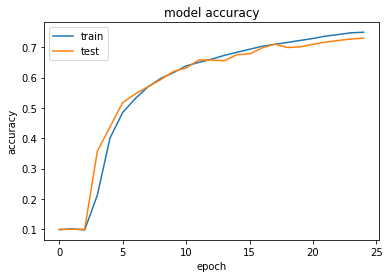

In [10]:
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

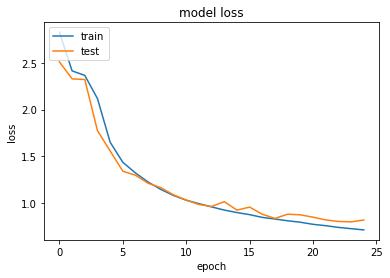

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Load Model**

In [9]:
# load weights into model
model.load_weights("/home/teresas/notebooks/deep_learning/files/load_CIFAR10/WRNet.h5", by_name=False)
print("Loaded model from disk")
# evaluate loaded model on test data
epochs = 25
lrate = 0.2
sgd = SGD(lr = lrate, momentum = 0.9, decay = 0.0005, nesterov = True, clipnorm=1., clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Loaded model from disk
acc: 73.00%


**Predictions**

In [12]:
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import toimage
import os

# create a numpy array with the desired shape
X_pred = np.zeros(shape = (12, 32, 32, 3), dtype=np.uint8)
# create a list with all images inside the directory
files = os.listdir('/home/teresas/notebooks/deep_learning/images/')

for i in range(X_pred.shape[0]):
    # open image file and store in variable `im`
    im = Image.open('/home/teresas/notebooks/deep_learning/images/' + files[i])
    X_pred[i] = np.asarray(im)

# normalize RGB
X_pred = X_pred.astype('float32')
X_pred = X_pred / 255.0
# output example: <class 'numpy.ndarray'> (50000, 32, 32, 3)
print(type(X_pred), X_pred.shape)

<class 'numpy.ndarray'> (12, 32, 32, 3)


deer: 98%
horse: 0%
bird: 0%


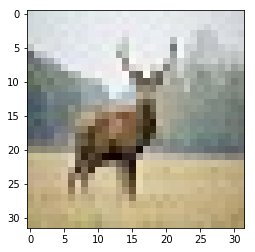

horse: 85%
deer: 13%
dog: 0%


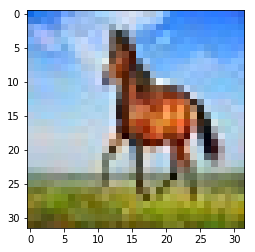

airplane: 95%
ship: 3%
bird: 0%


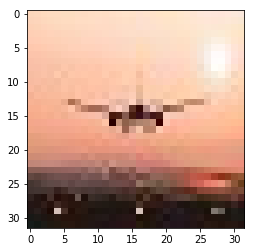

frog: 78%
cat: 15%
dog: 5%


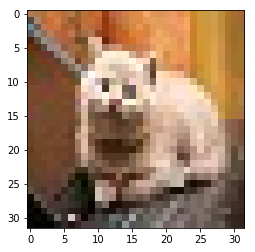

bird: 57%
dog: 18%
frog: 16%


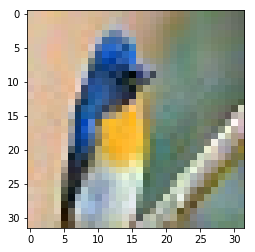

dog: 50%
cat: 39%
horse: 8%


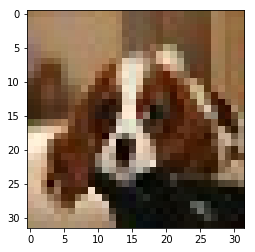

horse: 39%
cat: 28%
frog: 18%


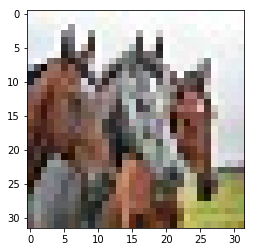

ship: 53%
bird: 28%
airplane: 15%


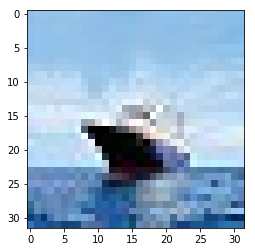

frog: 76%
bird: 20%
airplane: 1%


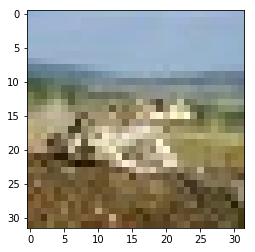

truck: 99%
automobile: 0%
airplane: 0%


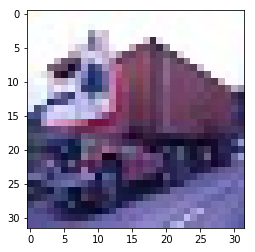

automobile: 68%
ship: 16%
truck: 12%


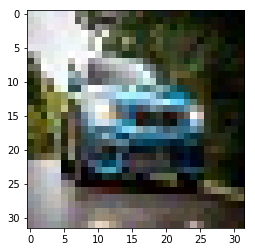

frog: 99%
cat: 0%
bird: 0%


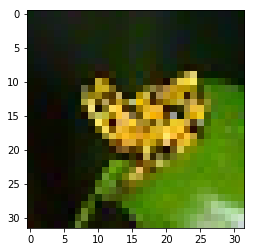

In [14]:
# calculate predictions
predictions = model.predict(X_pred)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(X_pred.shape[0]):
    b = list(predictions[i])
    first_max = sorted(predictions[i])[-1]
    second_max = sorted(predictions[i])[-2]
    third_max = sorted(predictions[i])[-3]
    print('%s: %d%%' % (classes[b.index(first_max)], first_max*100))
    print('%s: %d%%' % (classes[b.index(second_max)], second_max*100))
    print('%s: %d%%' % (classes[b.index(third_max)], third_max*100))
    plt.imshow(toimage(X_pred[i]))
    plt.show()